# __Colorectal Histology__

In [7]:
# load the dataset colorectal_histology from tensorflow_datasets and split into train validation and test

import tensorflow_datasets as tfds
import tensorflow as tf

data_info = tfds.builder('colorectal_histology').info
train_ds, val_ds, test_ds = tfds.load('colorectal_histology', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], as_supervised=True)

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [3]:
#let's look the info of the dataset

print(data_info)

tfds.core.DatasetInfo(
    name='colorectal_histology',
    full_name='colorectal_histology/2.0.0',
    description="""
    Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.
    """,
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    data_path='/home/cleltizia/tensorflow_datasets/colorectal_histology/2.0.0',
    file_format=tfrecord,
    download_size=246.14 MiB,
    dataset_size=179.23 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(150, 150, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=5000, num_shards=2>,
    },
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nik

In [4]:
# print the label names

print(data_info.features['label'].names)

['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty']


In [5]:
# print the number of samples in each split

print('Number of training samples: ', tf.data.experimental.cardinality(train_ds).numpy())
print('Number of validation samples: ', tf.data.experimental.cardinality(val_ds).numpy())
print('Number of test samples: ', tf.data.experimental.cardinality(test_ds).numpy())

Number of training samples:  4000
Number of validation samples:  500
Number of test samples:  500


In [6]:
# print the label of the first sample

for sample in train_ds.take(1):
    image, label = sample
    print('Label: ', label.numpy())

Label:  4


2022-12-18 13:19:45.410098: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2022-12-18 10:18:08.593050: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


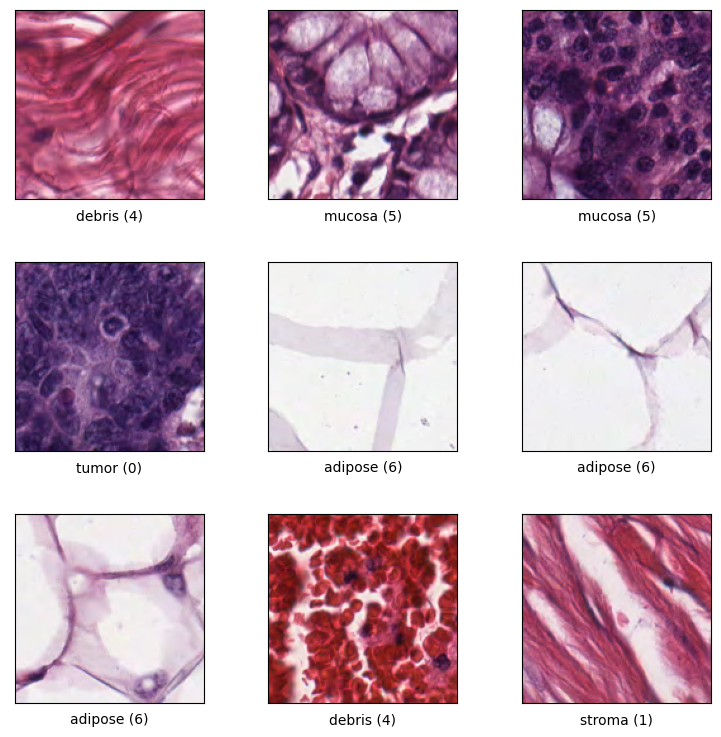

In [6]:
tfds.show_examples(train_ds,data_info);

# Pre-processing part

In [7]:
# let's look at the shape of the images

for image, label in train_ds.take(1):
    print('Image shape: ', image.numpy().shape)
    print('Label: ', label.numpy())

Image shape:  (150, 150, 3)
Label:  4


2022-12-18 13:19:48.799030: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [8]:
# build function to pre-process the images. In this function we will: normalize the image, batch the images and transform the image to float32.

BATCH_SIZE = 32
IMG_SIZE = (150, 150)

def preprocess_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

In [9]:
def one_hot_label(image, label):
    label = tf.one_hot(label, depth=8)
    return image, label

In [10]:
first_train_ds = train_ds.map(preprocess_image).map(one_hot_label).batch(BATCH_SIZE).prefetch(1)
first_val_ds = val_ds.map(preprocess_image).map(one_hot_label).batch(BATCH_SIZE).prefetch(1)
first_test_ds = test_ds.map(preprocess_image).map(one_hot_label).batch(BATCH_SIZE).prefetch(1)

In [11]:
first_train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

# First model

In [57]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


INPUT_SHAPE = first_train_ds.element_spec[0].shape[1:]

# build the model

first_model = Sequential()

first_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
first_model.add(MaxPooling2D(pool_size=(2,2)))

first_model.add(Conv2D(64, (3, 3), activation='relu'))
first_model.add(MaxPooling2D(pool_size=(2,2)))

first_model.add(Conv2D(128, (3, 3), activation='relu'))
first_model.add(MaxPooling2D(pool_size=(2,2)))

first_model.add(Flatten())

first_model.add(Dense(128, activation='relu'))
first_model.add(Dense(8, activation='softmax'))


first_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 17, 17, 128)    

In [58]:
# put a small learning rate to avoid overfitting

first_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
# train the model

first_history = first_model.fit(first_train_ds, epochs=20, validation_data=first_val_ds)

Epoch 1/20
125/125 [==============================] - 19s 153ms/step - loss: 1.2035 - accuracy: 0.4843 - val_loss: 0.8900 - val_accuracy: 0.6300
Epoch 2/20
125/125 [==============================] - 24s 193ms/step - loss: 0.7700 - accuracy: 0.6737 - val_loss: 0.7199 - val_accuracy: 0.7000
Epoch 3/20
125/125 [==============================] - 23s 186ms/step - loss: 0.6348 - accuracy: 0.7420 - val_loss: 0.6624 - val_accuracy: 0.7320
Epoch 4/20
125/125 [==============================] - 23s 186ms/step - loss: 0.5890 - accuracy: 0.7697 - val_loss: 0.6030 - val_accuracy: 0.7580
Epoch 5/20
125/125 [==============================] - 23s 181ms/step - loss: 0.5668 - accuracy: 0.7690 - val_loss: 0.6675 - val_accuracy: 0.7200
Epoch 6/20
125/125 [==============================] - 23s 181ms/step - loss: 0.4770 - accuracy: 0.8138 - val_loss: 0.7007 - val_accuracy: 0.7540
Epoch 7/20
125/125 [==============================] - 20s 160ms/step - loss: 0.3824 - accuracy: 0.8600 - val_loss: 0.9915 - val_ac

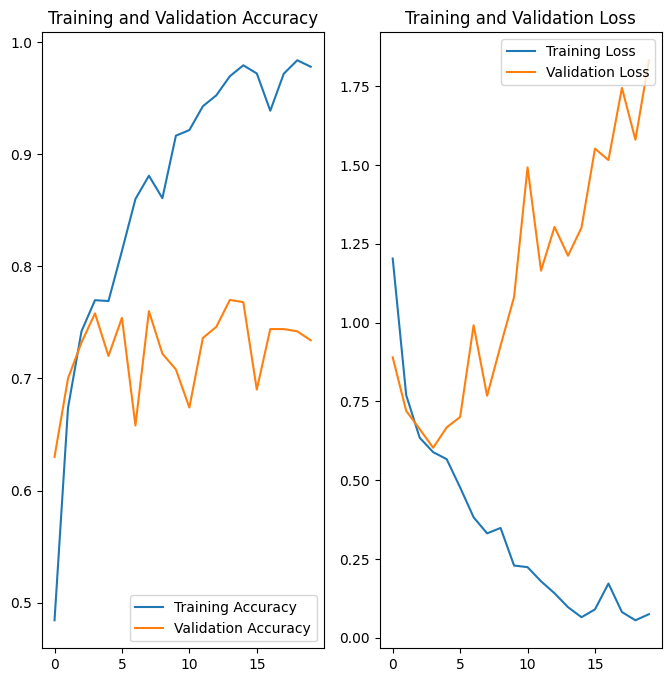

In [61]:
# plot the training and validation accuracy and loss at each epoch

import matplotlib.pyplot as plt

acc = first_history.history['accuracy']
val_acc = first_history.history['val_accuracy']

loss = first_history.history['loss']
val_loss = first_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

It's pretty obious something is wrong here, we have a huge gap between the training accuracy and the validation accuracy. We have a lot of overfitting.

In [63]:
# evaluate the model

first_model.evaluate(first_test_ds)

16/16 [==============================] - 1s 43ms/step - loss: 1.6914 - accuracy: 0.7280


[1.6914011240005493, 0.7279999852180481]

In [18]:
first_model.save('basic_model.h5')

In [62]:
# compute the confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

y_pred = first_model.predict(first_test_ds)
y_pred = tf.argmax(y_pred, axis=1)

y_true = []
for image, label in first_test_ds:
    y_true.extend(tf.argmax(label, axis=1))

first_accuracy = accuracy_score(y_true, y_pred)
first_f1_score = f1_score(y_true, y_pred, average='macro')

print('Accuracy :', first_accuracy)
print('F1 Score :', first_f1_score)

16/16 [==============================] - 1s 44ms/step
Accuracy : 0.728
F1 Score : 0.7161330971137234


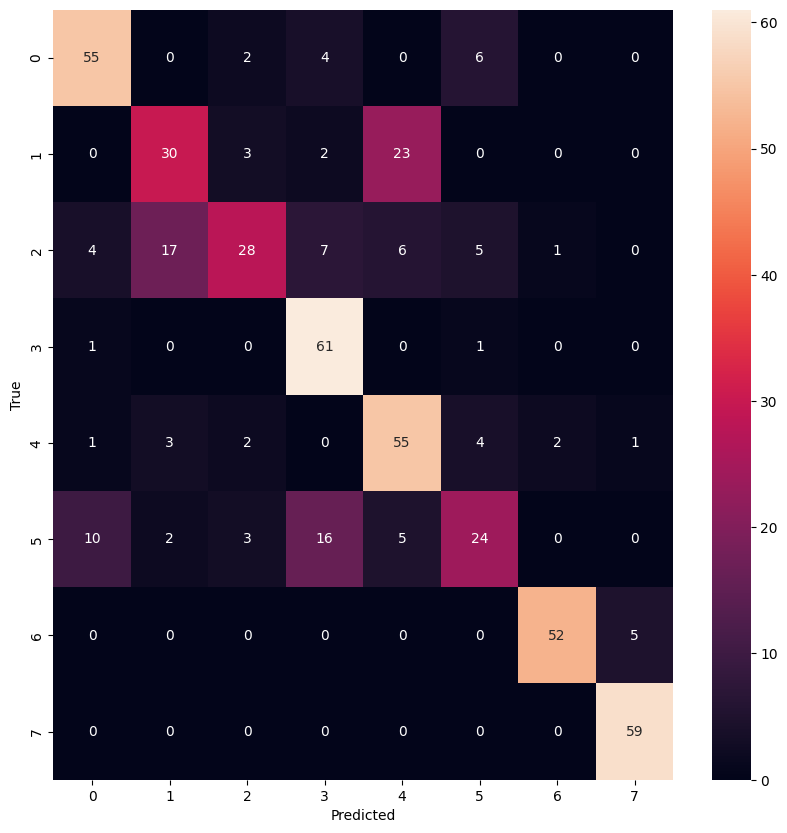

In [64]:
# plot the confusion matrix

import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Data augmentation

In [ ]:
# new datasets with augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen =  ImageDataGenerator(rotation_range=40, 
                                    shear_range=0.2, 
                                    zoom_range=0.2, 
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest')

# Second model

In [66]:
# make a model called second model with these new layers : batch normalization, dropout and data augmentation, and global average pooling

from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D

second_model = Sequential()

second_model.add(Conv2D(32, (3, 3), activation='gelu', input_shape=INPUT_SHAPE))
second_model.add(BatchNormalization())
second_model.add(MaxPooling2D(pool_size=(2,2)))

second_model.add(Conv2D(64, (3, 3), activation='gelu'))
second_model.add(BatchNormalization())
second_model.add(MaxPooling2D(pool_size=(2,2)))

second_model.add(Conv2D(128, (3, 3), activation='gelu'))
second_model.add(BatchNormalization())
second_model.add(MaxPooling2D(pool_size=(2,2)))

second_model.add(Conv2D(256, (3, 3), activation='gelu'))
second_model.add(BatchNormalization())
second_model.add(MaxPooling2D(pool_size=(2,2)))

second_model.add(Flatten())

second_model.add(Dropout(0.1))

second_model.add(Dense(256, activation='gelu'))
second_model.add(Dense(128, activation='gelu'))
second_model.add(Dense(8, activation='softmax'))

second_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       256       
 hNormalization)                                                 
                                                     

In [70]:
second_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
earlystop = tf.keras.callbacks.EarlyStopping('val_loss', patience=4, restore_best_weights=True)

In [71]:
second_history = second_model.fit(first_train_ds, epochs=20, validation_data=first_val_ds,callbacks=[earlystop])

Epoch 1/20
125/125 [==============================] - 48s 381ms/step - loss: 1.8978 - accuracy: 0.5828 - val_loss: 6.3819 - val_accuracy: 0.1160
Epoch 2/20
125/125 [==============================] - 48s 386ms/step - loss: 0.8523 - accuracy: 0.7283 - val_loss: 8.5434 - val_accuracy: 0.1160
Epoch 3/20
125/125 [==============================] - 49s 390ms/step - loss: 0.6159 - accuracy: 0.7925 - val_loss: 11.0932 - val_accuracy: 0.1160
Epoch 4/20
125/125 [==============================] - 49s 390ms/step - loss: 0.5102 - accuracy: 0.8205 - val_loss: 4.1566 - val_accuracy: 0.2540
Epoch 5/20
125/125 [==============================] - 49s 392ms/step - loss: 0.4382 - accuracy: 0.8460 - val_loss: 2.4328 - val_accuracy: 0.3580
Epoch 6/20
125/125 [==============================] - 51s 408ms/step - loss: 0.3154 - accuracy: 0.8885 - val_loss: 8.1924 - val_accuracy: 0.3980
Epoch 7/20
125/125 [==============================] - 44s 350ms/step - loss: 0.2628 - accuracy: 0.9062 - val_loss: 3.4305 - val_a

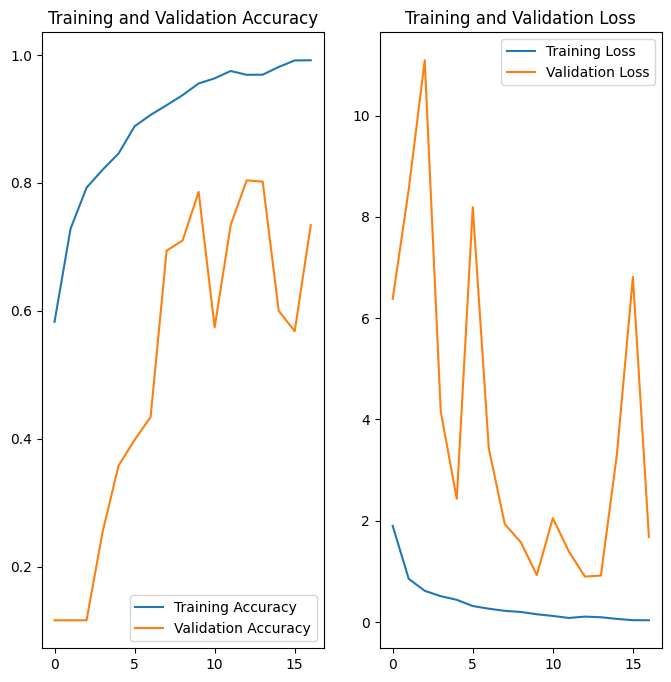

In [73]:
# plot the training and validation accuracy and loss at each epoch

import matplotlib.pyplot as plt

acc = second_history.history['accuracy']
val_acc = second_history.history['val_accuracy']

loss = second_history.history['loss']
val_loss = second_history.history['val_loss']

epochs_range = range(17)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [74]:
# evaluate the model

second_model.evaluate(first_test_ds)

16/16 [==============================] - 2s 99ms/step - loss: 1.1044 - accuracy: 0.7800


[1.1043542623519897, 0.7799999713897705]

In [75]:
# save the accuracy and f1 score of the model

y_pred = second_model.predict(first_test_ds)
y_pred = tf.argmax(y_pred, axis=1)

y_true = []
for image, label in first_test_ds:
    y_true.extend(tf.argmax(label, axis=1))

second_accuracy = accuracy_score(y_true, y_pred)
second_f1_score = f1_score(y_true, y_pred, average='macro')

print('Accuracy :', second_accuracy)
print('F1 Score :', second_f1_score)

16/16 [==============================] - 2s 98ms/step
Accuracy : 0.78
F1 Score : 0.7737884902820118


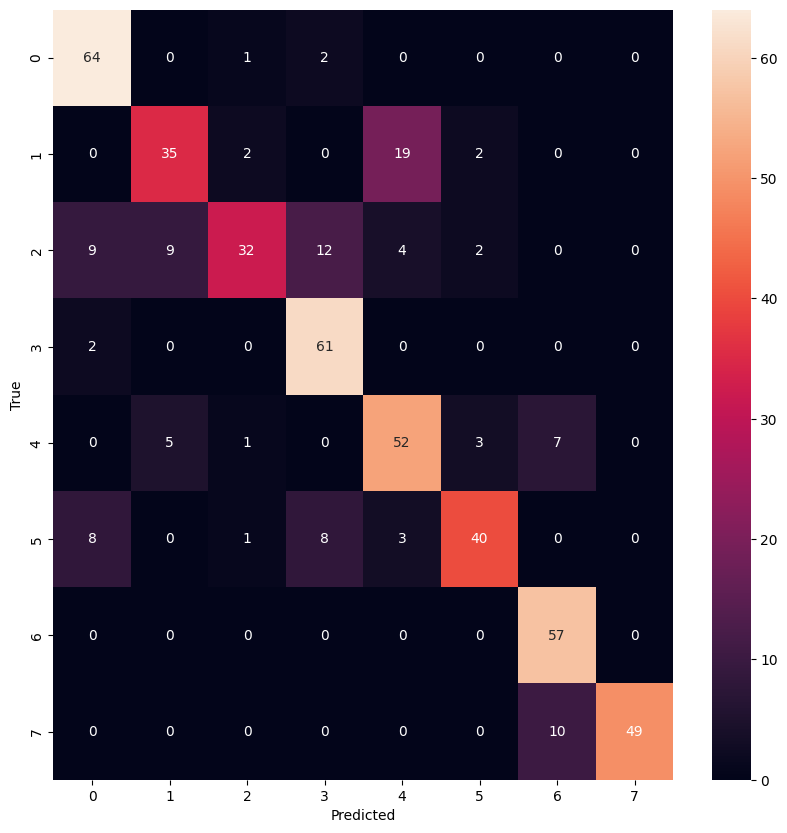

In [76]:
confusion_matrix(y_true, y_pred)

# plot the confusion matrix

import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Grid search
(not resolved)

In [1]:
# create a gridSearchCV to find the best hyperparameters of second_model

import numpy as np

import tensorflow as tf

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV

def build_model(optimizer):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='gelu', input_shape=INPUT_SHAPE))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='gelu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), activation='gelu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), activation='gelu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Dropout(0.1))

    model.add(Dense(256, activation='gelu'))
    model.add(Dense(128, activation='gelu'))
    model.add(Dense(8, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=build_model)

earlystop_4 = tf.keras.callbacks.EarlyStopping('val_loss', patience=4, restore_best_weights=True)
earlystop_5 = tf.keras.callbacks.EarlyStopping('val_loss', patience=5, restore_best_weights=True)
earlystop_6 = tf.keras.callbacks.EarlyStopping('val_loss', patience=6, restore_best_weights=True)

parameters = {'batch_size': [32, 64, 128],
                'epochs': [20, 30, 40],
                'optimizer': ['adam', 'rmsprop'],
                'callbacks': [earlystop_4, earlystop_5, earlystop_6],
                'shuffle': [True, False]}

grid_search = GridSearchCV(estimator=model,
                            param_grid=parameters,
                            scoring='accuracy',
                            cv=3)

# save in X the features and in y the labels

X = []
y = []

for image, label in first_train_ds:
    X.append(image.numpy())
    y.append(label.numpy())

X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

# transform X and y to the right shape, the model attend (150,150,3) and (8,) respectively

X = X.reshape(125, 150, 150, 3)
y = y.reshape(125, 8)

# fit the gridSearchCV

grid_search = grid_search.fit(X, y)

best_parameters = grid_search.best_params_

best_accuracy = grid_search.best_score_

2022-12-18 13:18:09.285471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 13:18:09.779849: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-18 13:18:09.944097: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-18 13:18:09.944121: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

NameError: name 'tf' is not defined

# Third model

In [33]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D, Dropout


INPUT_SHAPE = first_train_ds.element_spec[0].shape[1:]
earlystop_20 = tf.keras.callbacks.EarlyStopping('val_loss', patience=20, restore_best_weights=True)

# build the model with 7 blocks of convolutional layers and maxpooling and avergae pooling alternatively

third_model = Sequential()

third_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE, padding='same'))
third_model.add(MaxPooling2D(pool_size=(2,2)))

third_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
third_model.add(AveragePooling2D(pool_size=(2,2)))

third_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
third_model.add(MaxPooling2D(pool_size=(2,2)))

third_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
third_model.add(AveragePooling2D(pool_size=(2,2)))

third_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
third_model.add(MaxPooling2D(pool_size=(2,2)))

third_model.add(Flatten())

third_model.add(Dropout(0.2))

third_model.add(Dense(256, activation='relu'))
third_model.add(Dense(128, activation='relu'))
third_model.add(Dense(8, activation='softmax'))

third_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 average_pooling2d_14 (Avera  (None, 37, 37, 64)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_39 (Conv2D)          (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 18, 18, 128)     

In [36]:
third_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
third_history = third_model.fit(first_train_ds, epochs=40, validation_data=first_val_ds, callbacks=[earlystop_6])

Epoch 1/40
125/125 [==============================] - 37s 294ms/step - loss: 1.4140 - accuracy: 0.3713 - val_loss: 1.0325 - val_accuracy: 0.5700
Epoch 2/40
125/125 [==============================] - 41s 327ms/step - loss: 0.9536 - accuracy: 0.5872 - val_loss: 0.8203 - val_accuracy: 0.6100
Epoch 3/40
125/125 [==============================] - 41s 327ms/step - loss: 0.8778 - accuracy: 0.6327 - val_loss: 0.8218 - val_accuracy: 0.6900
Epoch 4/40
125/125 [==============================] - 41s 327ms/step - loss: 0.7300 - accuracy: 0.7072 - val_loss: 0.6652 - val_accuracy: 0.7300
Epoch 5/40
125/125 [==============================] - 41s 327ms/step - loss: 0.7220 - accuracy: 0.7113 - val_loss: 0.6337 - val_accuracy: 0.7720
Epoch 6/40
125/125 [==============================] - 41s 326ms/step - loss: 0.6407 - accuracy: 0.7437 - val_loss: 0.5456 - val_accuracy: 0.7860
Epoch 7/40
125/125 [==============================] - 41s 329ms/step - loss: 0.5633 - accuracy: 0.7872 - val_loss: 0.6190 - val_ac

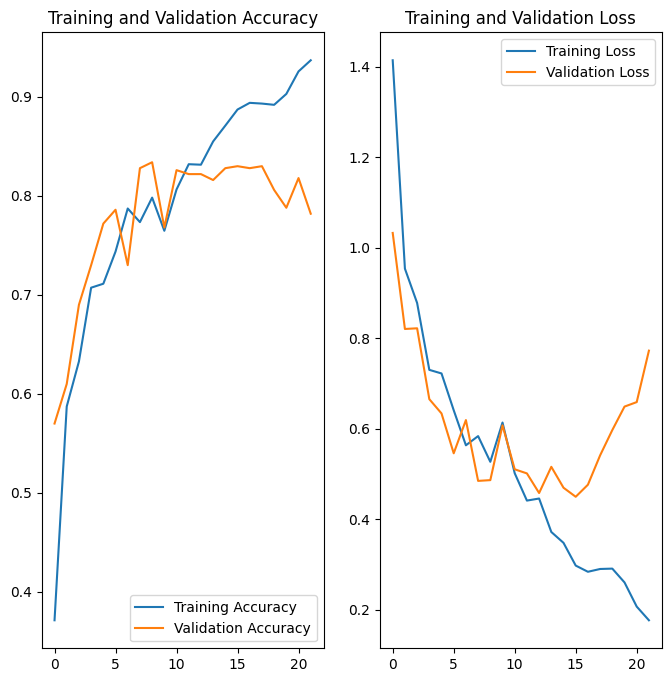

In [39]:
# plot the training and validation accuracy and loss at each epoch

import matplotlib.pyplot as plt

acc = third_history.history['accuracy']
val_acc = third_history.history['val_accuracy']

loss = third_history.history['loss']
val_loss = third_history.history['val_loss']

epochs_range = range(22)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
third_model.evaluate(first_test_ds)

16/16 [==============================] - 1s 77ms/step - loss: 0.5038 - accuracy: 0.8220


[0.5037990212440491, 0.8220000267028809]

In [79]:
# save the accuracy and f1 score of the model

y_pred = third_model.predict(first_test_ds)
y_pred = tf.argmax(y_pred, axis=1)

y_true = []
for image, label in first_test_ds:
    y_true.extend(tf.argmax(label, axis=1))

third_accuracy = accuracy_score(y_true, y_pred)
third_f1_score = f1_score(y_true, y_pred, average='macro')

print('Accuracy :', third_accuracy)
print('F1 Score :', third_f1_score)

16/16 [==============================] - 1s 79ms/step
Accuracy : 0.822
F1 Score : 0.8230469208494613


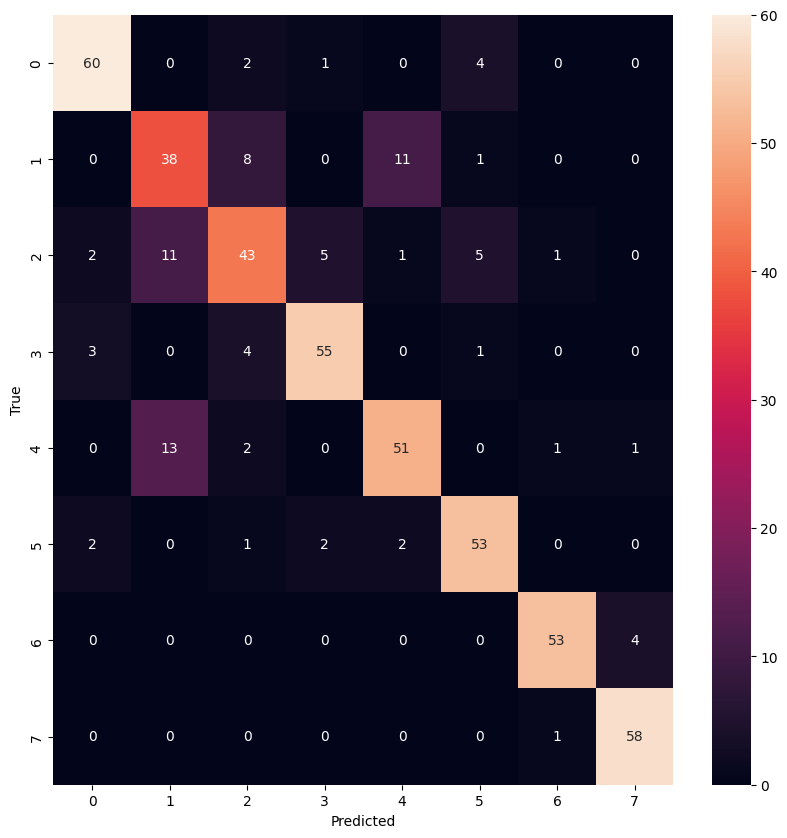

In [80]:
confusion_matrix(y_true, y_pred)

# plot the confusion matrix

import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Final model

In [41]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D, Dropout


INPUT_SHAPE = first_train_ds.element_spec[0].shape[1:]
earlystop_20 = tf.keras.callbacks.EarlyStopping('val_loss', patience=20, restore_best_weights=True)

# build the model with 7 blocks of convolutional layers and maxpooling and avergae pooling alternatively

final_model = Sequential()

final_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE, padding='same'))
final_model.add(MaxPooling2D(pool_size=(2,2)))

final_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
final_model.add(AveragePooling2D(pool_size=(2,2)))

final_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
final_model.add(MaxPooling2D(pool_size=(2,2)))

final_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
final_model.add(AveragePooling2D(pool_size=(2,2)))

final_model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
final_model.add(MaxPooling2D(pool_size=(2,2)))

final_model.add(Flatten())

final_model.add(Dropout(0.5))

final_model.add(Dense(256, activation='relu'))
final_model.add(Dense(128, activation='relu'))
final_model.add(Dense(8, activation='softmax'))

final_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 average_pooling2d_16 (Avera  (None, 37, 37, 64)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_44 (Conv2D)          (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 18, 18, 128)     

In [42]:
final_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
final_history = final_model.fit(first_train_ds, epochs=40, validation_data=first_val_ds, callbacks=[earlystop_20])

Epoch 1/40
125/125 [==============================] - 37s 295ms/step - loss: 1.8207 - accuracy: 0.2585 - val_loss: 1.6285 - val_accuracy: 0.2560
Epoch 2/40
125/125 [==============================] - 41s 330ms/step - loss: 1.2759 - accuracy: 0.4448 - val_loss: 2.3918 - val_accuracy: 0.3400
Epoch 3/40
125/125 [==============================] - 42s 333ms/step - loss: 1.0770 - accuracy: 0.5508 - val_loss: 1.4293 - val_accuracy: 0.4580
Epoch 4/40
125/125 [==============================] - 42s 332ms/step - loss: 0.9061 - accuracy: 0.6370 - val_loss: 0.9785 - val_accuracy: 0.5840
Epoch 5/40
125/125 [==============================] - 42s 333ms/step - loss: 0.7956 - accuracy: 0.6975 - val_loss: 0.8272 - val_accuracy: 0.6600
Epoch 6/40
125/125 [==============================] - 42s 333ms/step - loss: 0.6871 - accuracy: 0.7427 - val_loss: 0.7212 - val_accuracy: 0.7380
Epoch 7/40
125/125 [==============================] - 42s 332ms/step - loss: 0.6518 - accuracy: 0.7613 - val_loss: 0.5061 - val_ac

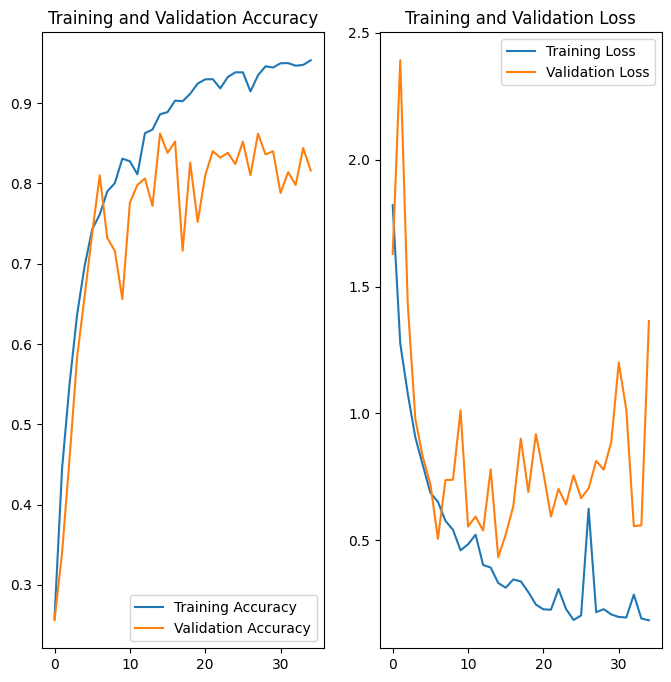

In [45]:
# plot the training and validation accuracy and loss at each epoch

import matplotlib.pyplot as plt

acc = final_history.history['accuracy']
val_acc = final_history.history['val_accuracy']

loss = final_history.history['loss']
val_loss = final_history.history['val_loss']

epochs_range = range(35)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [46]:
final_model.evaluate(first_test_ds)

16/16 [==============================] - 1s 77ms/step - loss: 0.5179 - accuracy: 0.8460


[0.5179105401039124, 0.8460000157356262]

We are really close to the objective which was 0.85 accuracy.

In [81]:
# save the accuracy and f1 score of the model

y_pred = final_model.predict(first_test_ds)
y_pred = tf.argmax(y_pred, axis=1)

y_true = []
for image, label in first_test_ds:
    y_true.extend(tf.argmax(label, axis=1))

final_accuracy = accuracy_score(y_true, y_pred)
final_f1_score = f1_score(y_true, y_pred, average='macro')

print('Accuracy :', final_accuracy)
print('F1 Score :', final_f1_score)

16/16 [==============================] - 1s 77ms/step
Accuracy : 0.846
F1 Score : 0.8492499546617764


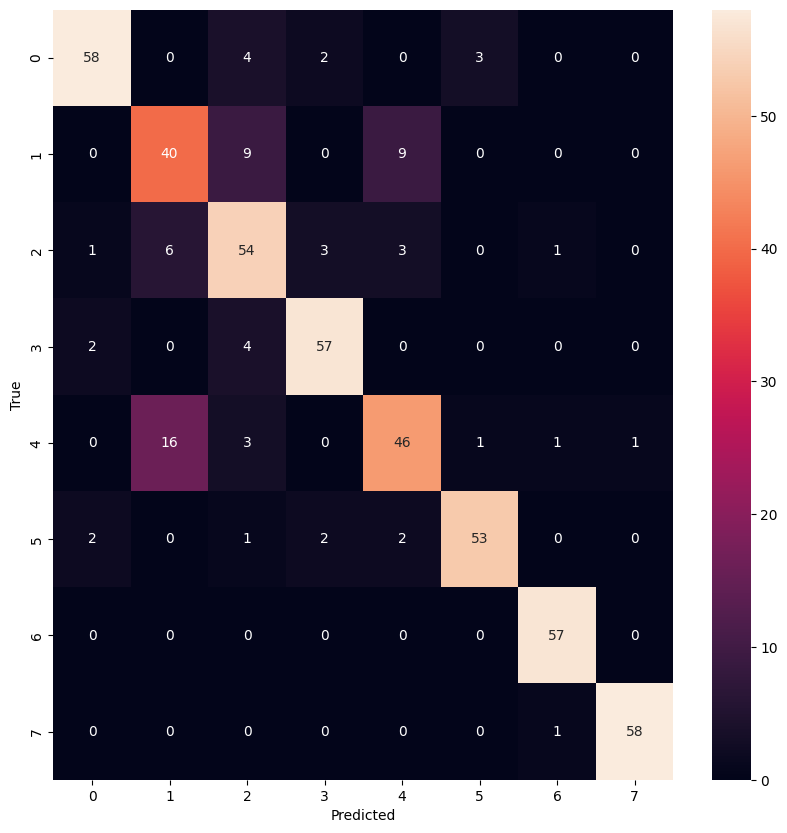

In [82]:
confusion_matrix(y_true, y_pred)

# plot the confusion matrix

import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Comparison of the four models

In [3]:
# let's compare the performance of all the models with th accuracy and loss of all the models and create a dataframe with the accuracy and f1 score of all the models

import pandas as pd

model_accuracy = [first_accuracy, second_accuracy, third_accuracy, third_accuracy, final_accuracy]
model_f1_score = [first_f1_score, second_f1_score, third_f1_score, third_f1_score, final_f1_score]

model_performance = pd.DataFrame({'Accuracy': model_accuracy, 'F1 Score': model_f1_score}, index=['First Model', 'Second Model', 'Third Model', 'Final Model'])
model_performance


NameError: name 'first_accuracy' is not defined

# Using an existing model 

In [47]:
# build RESNET50 model

from tensorflow.keras.applications import ResNet50

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

resnet.trainable = False

resnet_model = Sequential()

resnet_model.add(resnet)

resnet_model.add(Flatten())

resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(8, activation='softmax'))

resnet_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_7 (Flatten)         (None, 51200)             0         
                                                                 
 dense_21 (Dense)            (None, 128)               6553728   
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 30,142,472
Trainable params: 6,554,760
Non-trainable params: 23,587,712
_________________________________________________________________


In [48]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
resnet_history = resnet_model.fit(first_train_ds, epochs=20, validation_data=first_val_ds)

Epoch 1/20
125/125 [==============================] - 71s 555ms/step - loss: 2.1695 - accuracy: 0.1912 - val_loss: 1.7572 - val_accuracy: 0.2620
Epoch 2/20
125/125 [==============================] - 77s 614ms/step - loss: 1.7792 - accuracy: 0.2428 - val_loss: 1.6704 - val_accuracy: 0.3360
Epoch 3/20
125/125 [==============================] - 76s 605ms/step - loss: 1.6971 - accuracy: 0.2570 - val_loss: 1.5807 - val_accuracy: 0.3520
Epoch 4/20
125/125 [==============================] - 77s 613ms/step - loss: 1.6683 - accuracy: 0.2770 - val_loss: 1.5261 - val_accuracy: 0.3660
Epoch 5/20
125/125 [==============================] - 75s 601ms/step - loss: 1.6414 - accuracy: 0.2855 - val_loss: 1.4647 - val_accuracy: 0.3940
Epoch 6/20
125/125 [==============================] - 75s 604ms/step - loss: 1.6099 - accuracy: 0.3047 - val_loss: 1.4966 - val_accuracy: 0.3520
Epoch 7/20
125/125 [==============================] - 77s 615ms/step - loss: 1.6117 - accuracy: 0.3002 - val_loss: 1.4065 - val_ac